# Credit Card Analysis and Fraud Detection

##### We need to import some libraries and create the engine to connect with the DB

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
# Do all the graphs with the same figsize

driver = 'mysql+pymysql:'
user = 'root'
#password = ''
ip = '127.0.0.1'
db = 'Final_project'
connection_string = f'{driver}//{user}:{password}@{ip}/{db}'

In [174]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

Creating a function that print confusion matrix and classification report based in a model

In [175]:
def result(model):
    """
    Get a fitted model from the user and does a predict. It prints a confusion matrix and a classification_report.
    :param model
    :return No return (shows confusion matrix and classification report in console with print):
    """
    from sklearn.metrics import confusion_matrix, classification_report
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [176]:
def PCA_plot(X, y):
    """
    Get a X and y that will be used for fitting a model and performs a PCA(n_components = 2) for being able to plot it
    :param X : array or df 
    :param y : array or series
    :return No return (plot a Seaborn Scatterplot with the dataset in 2d):
    """
    PCA_model = PCA(n_components = 2)
    X_pca = PCA_model.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)
    sns.scatterplot(X_pca[0], X_pca[1], hue = y)
    plt.show()

In [177]:
def clean_df(df):
    """
    Get the dataframe and cleans it. Will only work with this dataset.
    :param df : pandas dataframe
    :return X, y ready to be scaled for fitting the models :)
    """
    df.Transaction_Date = pd.to_datetime(df['Transaction_Date'], yearfirst = True)
    df['Transaction_Date'] = pd.to_numeric(df['Transaction_Date'])
    df.reset_index(inplace = True, drop = True)
    X = df.drop(columns = ['credit_card_id', 'Transaction_ID', 'Transaction_Segment'])
    X = pd.get_dummies(X, drop_first = True)
    y = X.pop('Fraud_flag')
    return X, y

Importing information from the DB

In [178]:
query = """SELECT Transaction_base.credit_card_id, Transaction_base.Transaction_Date, 
Transaction_base.Transaction_Value, Card_base.Card_Family, Card_base.Credit_limit, Customer_base.Age, 
Transaction_base.Transaction_ID, Transaction_base.Transaction_Segment, IFNULL(Fraud_base.Fraud_Flag,0) as Fraud_flag
FROM Transaction_base 
LEFT JOIN Fraud_base
ON Transaction_base.Transaction_ID = Fraud_base.Transaction_ID
LEFT JOIN Card_base
ON Transaction_base.Credit_Card_ID = Card_base.Card_Number
LEFT JOIN Customer_base
ON Card_base.Cust_ID = Customer_base.Cust_ID;"""
engine = create_engine(connection_string)

In [179]:
transaction_df = pd.read_sql(query, engine)

In [180]:
transaction_df_original = transaction_df.copy()

In [222]:
transaction_df = transaction_df_original.copy() # I created a copy for not having to do the read_sql if I want to restart the jupyter

In [182]:
transaction_df.head()

,credit_card_id,Transaction_Date,Transaction_Value,Card_Family,Credit_limit,Age,Transaction_ID,Transaction_Segment,Fraud_flag
0,1629-9566-3285-2123,2016-04-24,23649.0,Platinum,194000,23,CTID28830551,SEG25,0
1,3697-6001-4909-5350,2016-02-11,26726.0,Gold,15000,48,CTID45504917,SEG16,0
2,5864-4475-3659-1440,2016-11-01,22012.0,Gold,2000,23,CTID47312290,SEG14,0
3,5991-4421-8476-3804,2016-01-28,37637.0,Gold,19000,44,CTID25637718,SEG17,0
4,1893-8853-9900-8478,2016-03-17,5113.0,Premium,417000,42,CTID66743960,SEG14,0


In [223]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
credit_card_id         10000 non-null object
Transaction_Date       10000 non-null object
Transaction_Value      10000 non-null float64
Card_Family            10000 non-null object
Credit_limit           10000 non-null int64
Age                    10000 non-null int64
Transaction_ID         10000 non-null object
Transaction_Segment    10000 non-null object
Fraud_flag             10000 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 703.2+ KB


We check if the fraud_flag column is imbalanced (Yes, it is!)

In [225]:
transaction_df['Fraud_flag'].value_counts()

0    9891
1     109
Name: Fraud_flag, dtype: int64

In [226]:
transaction_df['Fraud_flag'].value_counts()[1]/transaction_df['Fraud_flag'].value_counts()[0]*100

1.1020119300374078

In [325]:
query = """SELECT * FROM Card_base;"""
engine = create_engine(connection_string)

In [326]:
card_df = pd.read_sql(query, engine)

In [358]:
card_df.groupby('Card_Family')['Card_Family'].count()

Card_Family
Gold        181
Platinum    112
Premium     207
Name: Card_Family, dtype: int64

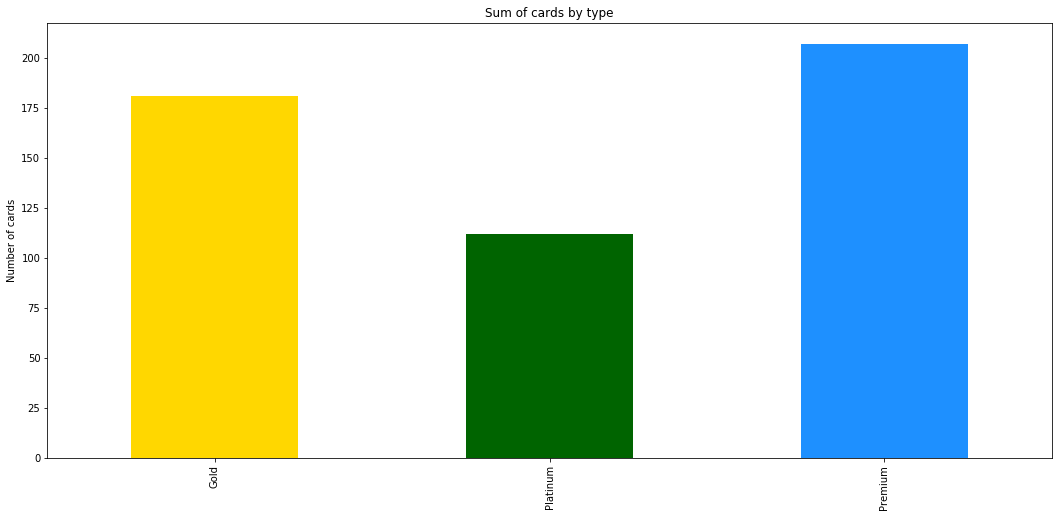

In [332]:
card_df.groupby('Card_Family')['Card_Family'].count().plot(kind = 'bar', color = ['gold', 'darkgreen', 'dodgerblue'])
plt.xlabel('')
plt.ylabel('Number of cards')
plt.title('Sum of cards by type')
plt.show()

In [333]:
query = """SELECT Customer_base.Age, Customer_segmentation.Customer_Segment
FROM Customer_base
LEFT JOIN Customer_segmentation
ON Customer_base.Customer_Segment = Customer_segmentation.Key;
"""
engine = create_engine(connection_string)

In [334]:
age_df = pd.read_sql(query, engine)

In [335]:
age_df.head()

,Age,Customer_Segment
0,22,Diamond
1,48,Diamond
2,47,Diamond
3,39,Diamond
4,28,Diamond


In [364]:
age_df.groupby('Customer_Segment').mean()['Age']

Customer_Segment
Diamond     35.124802
Gold        35.008157
Platinum    35.007628
Name: Age, dtype: float64

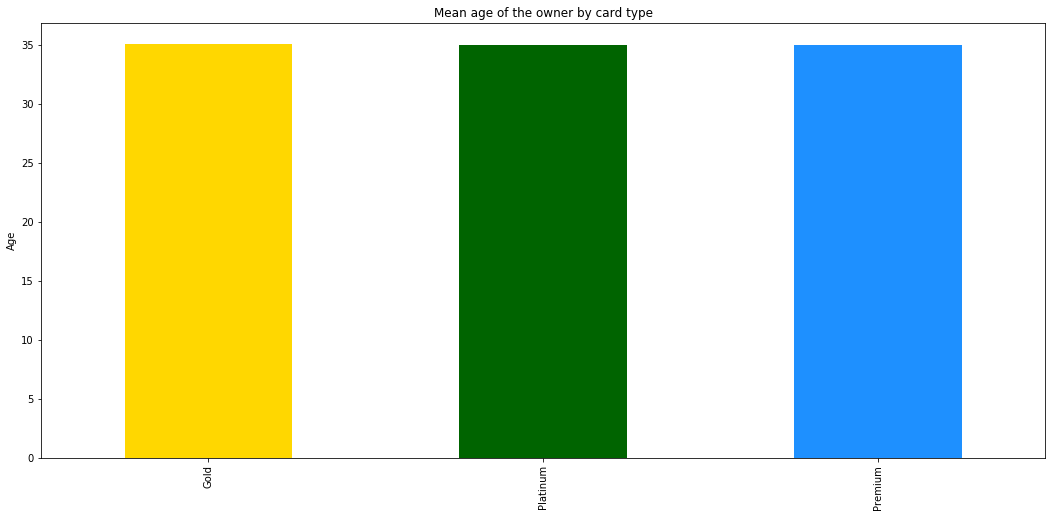

In [365]:
age_df.groupby('Customer_Segment').mean()['Age'].plot(kind = 'bar', color = ['gold', 'darkgreen', 'dodgerblue'])
plt.xticks(ticks=[0,1,2], labels=['Gold','Platinum','Premium'],rotation=90)
plt.xlabel('')
plt.ylabel('Age')
plt.title('Mean age of the owner by card type')
plt.show()

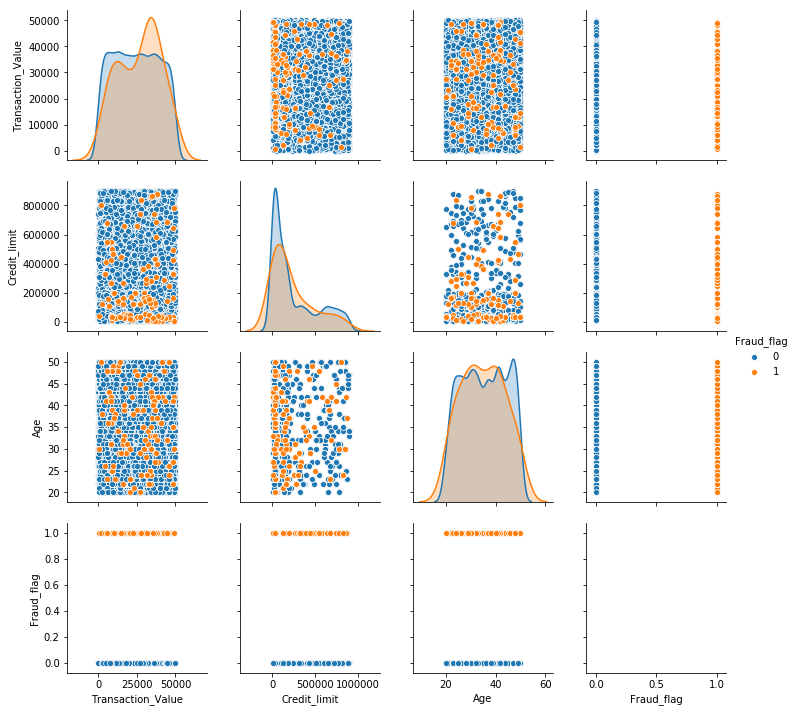

In [227]:
sns.pairplot(transaction_df, hue = 'Fraud_flag')
plt.show()

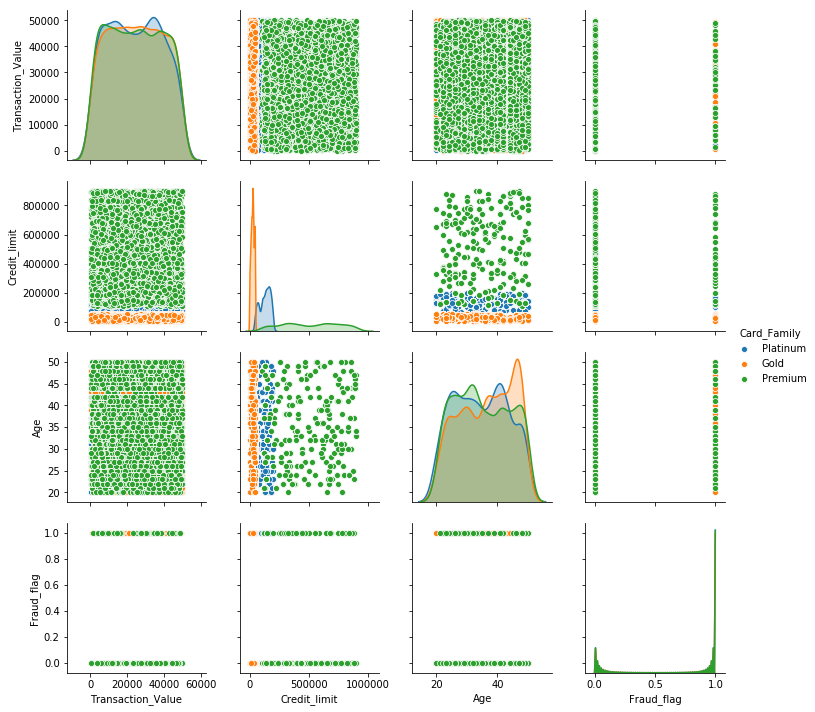

In [228]:
sns.pairplot(transaction_df, hue = 'Card_Family')
plt.show()

In [229]:
X, y = clean_df(transaction_df)

In [230]:
heatmap_df = pd.concat([X,y], axis = 1)

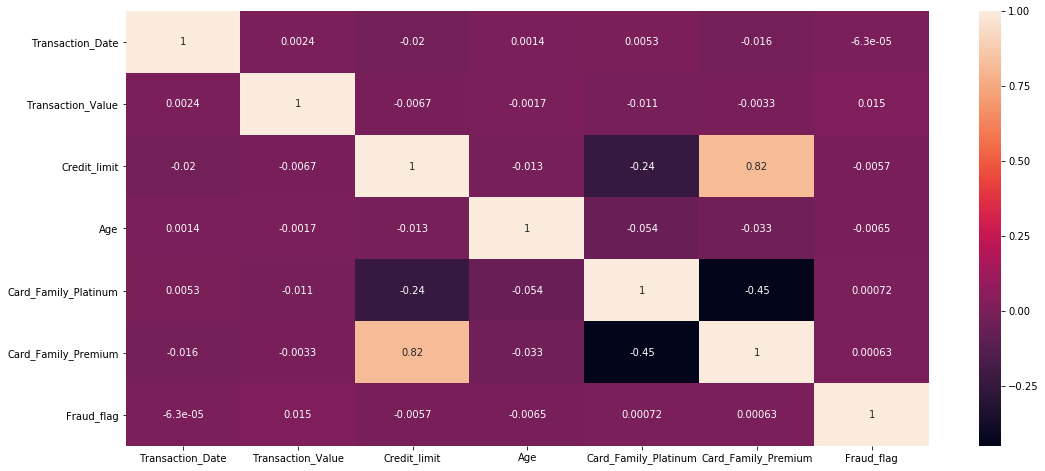

In [231]:
sns.heatmap(heatmap_df.corr(), annot = True)
plt.show()

# We have so many differences in the units so we need to scale

In [190]:
from sklearn.preprocessing import scale
X = scale(X)

Before doing the oversampling let's do the train-test split of the data

In [191]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

I'm going to use PCA to see how features are afecting the explained variance

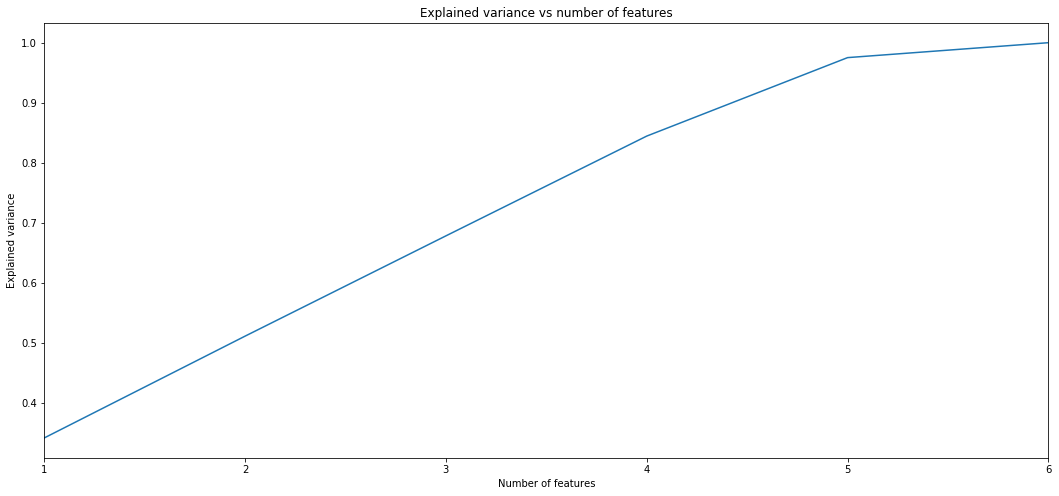

In [192]:
PCA_var = PCA(n_components = 6)
PCA_var.fit(X)
ratio = PCA_var.explained_variance_ratio_
ratio = pd.DataFrame(ratio)
ratio.sort_index().cumsum().plot(legend = False)
plt.xlabel('Number of features')
plt.ylabel('Explained variance')
plt.xticks(labels = ['1','2','3','4','5', '6'], ticks = [0,1,2,3,4,5])
plt.title('Explained variance vs number of features')
plt.show()

Actually we can get all the features because we don't have so many features nor rows so the computer will be able to handle it well.

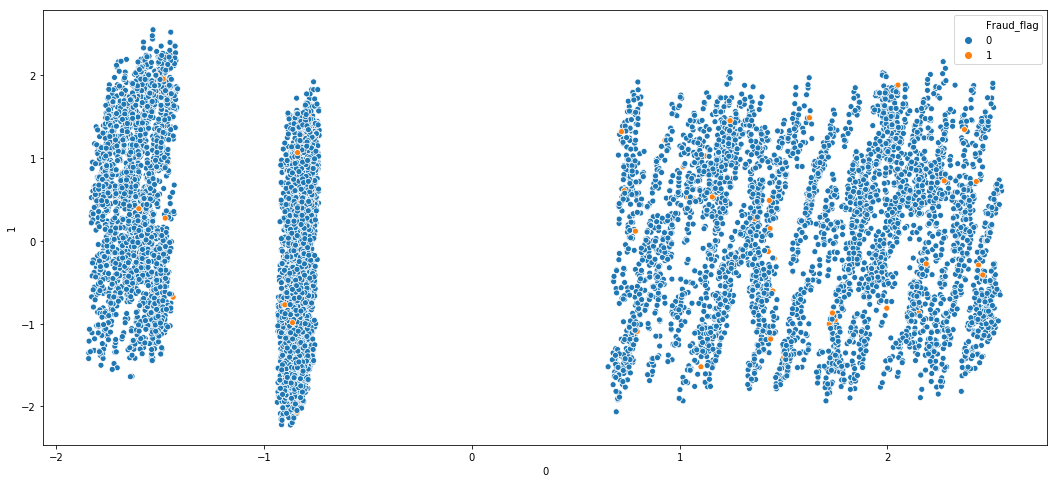

In [193]:
PCA_plot(X,y)

We use PCA to convert the X to 2 dimension to be able to plot it and compare it with the other techniques.

# To fight against imbalance classes we need to use some techniques, the first one we are going to use is Synthetic Minority Over-sampling Technique (SMOTE)

To illustrate how this technique works consider some training data which has s samples, and f features in the feature space of the data. Note that these features, for simplicity, are continuous. As an example, consider a dataset of birds for classification. The feature space for the minority class for which we want to oversample could be beak length, wingspan, and weight (all continuous). To then oversample, take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point. Source: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE

In [194]:
from imblearn import over_sampling
from collections import Counter

In [195]:
resample = over_sampling.SMOTE(random_state = 12, ratio = 1)

In [196]:
X_smote, y_smote = resample.fit_sample(X_train,y_train)

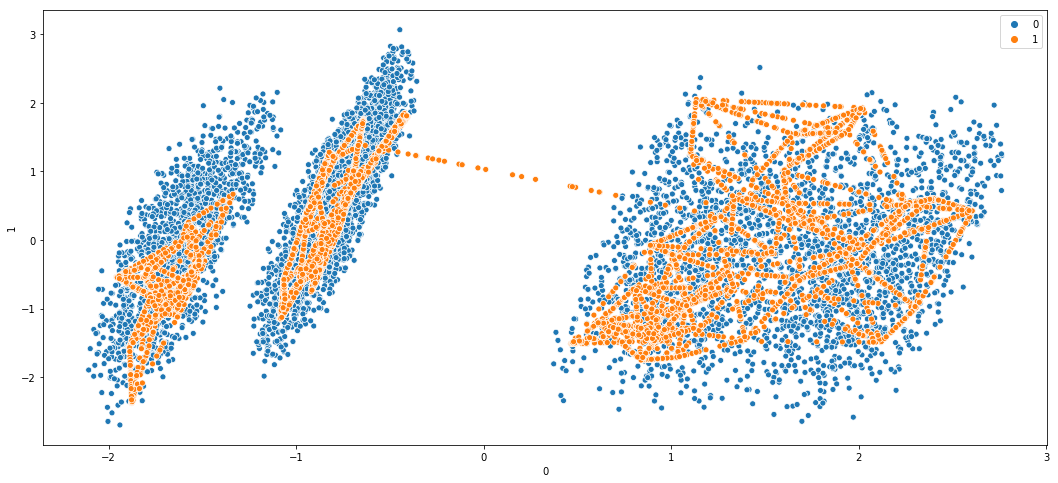

In [197]:
PCA_plot(X_smote, y_smote)

As said before, we use PCA to convert the X to 2 dimension to be able to plot it and compare it with the other techniques.

In [198]:
Counter(y_smote)

Counter({0: 6922, 1: 6922})

In [199]:
len(X_smote)

13844

# Now let's try with another oversampling technique

In [200]:
class_0 = transaction_df[transaction_df['Fraud_flag'] == 0]
class_1 = transaction_df[transaction_df['Fraud_flag'] == 1]

In [201]:
len(class_0),len(class_1)

(9891, 109)

In [202]:
class_1_over = class_1.sample(len(class_0), replace=True)

In [203]:
len(class_0),len(class_1_over)

(9891, 9891)

In [204]:
transaction_df_sample = pd.concat([class_0,class_1_over], axis = 0)

In [205]:
X_sample, y_sample = clean_df(transaction_df_sample)

In [206]:
X_sample = scale(X_sample)

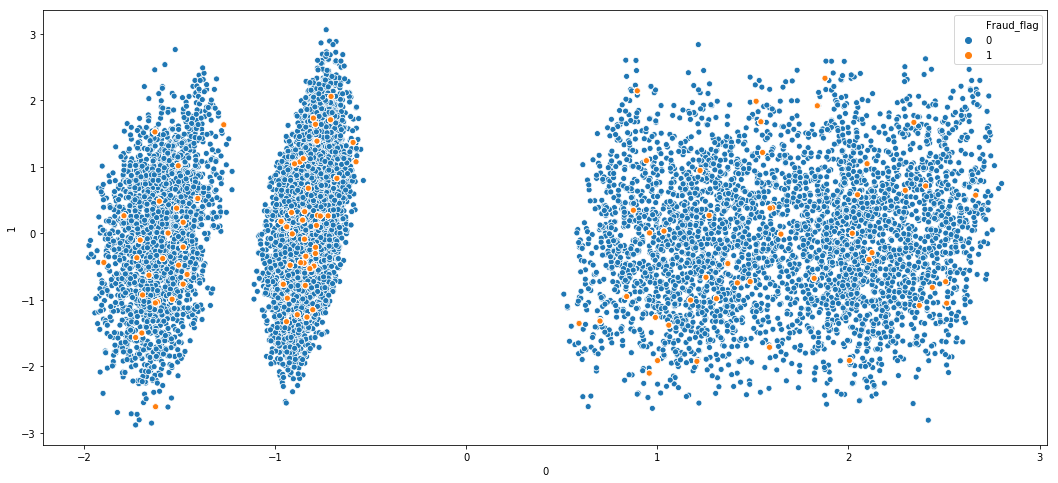

In [207]:
PCA_plot(X_sample, y_sample)

As said before, we use PCA to convert the X to 2 dimension to be able to plot it and compare it with the other techniques.
If we want to use this technique we should do the train-test split before doing the oversampling!!!

So we will use the SMOTE oversampling for the machine learning models.

# Now we have to select some machine learning models

### Watching the scikit-learn cheat sheet, we need to select the K Nearest Neighbors (KNN), so let's import the model and train it!

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. Source: https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [208]:
%time
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1).fit(X_smote, y_smote)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


In [209]:
result(KNN_model)

[[2525  444]
 [  29    2]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2969
           1       0.00      0.06      0.01        31

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.50      0.46      0.46      3000
weighted avg       0.98      0.84      0.90      3000



NEED TO EDIT THIS. The first part of the result is the confusion matrix. So what is a confusion matrix? It's a matrix of 2x2 where we can find (top left) the True Positive: the model is classifying 1650 as nonfraud and they are actually nonfraud, (bottom left) the model is classifying 28 as a fraud when they are actually nonfraud. (top right) 358 are fraudulent transactions that are actually classified as nonfraud and 1921 transactions are actually well classified as fraud operations. We can also check the f1-score and see that is 0.9 for non-fraud values and 0.91 for fraud values (f1-score is a measure of the effectiveness of the classification model)

### Now let's try the RandomForestClassifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default). Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [284]:
%time
from sklearn.ensemble import RandomForestClassifier
RFC_model = RandomForestClassifier(max_depth = 13, n_jobs = -1, random_state = 12, min_samples_split = 10).fit(X_smote, y_smote)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [285]:
result(RFC_model)

[[2668  301]
 [  27    4]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2969
           1       0.01      0.13      0.02        31

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.50      0.51      0.48      3000
weighted avg       0.98      0.89      0.93      3000



As we see this model is performing better than KNN model.

### Now let's try the XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. Source: https://xgboost.readthedocs.io/en/latest/

In [212]:
%time
from xgboost import XGBClassifier
XGB_model = XGBClassifier(max_depth = 12, random_state = 12, n_jobs = -1, n_estimators = 300)
XGB_model.fit(X_smote, y_smote)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [213]:
result(XGB_model)

[[2954   15]
 [  30    1]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2969
           1       0.06      0.03      0.04        31

   micro avg       0.98      0.98      0.98      3000
   macro avg       0.53      0.51      0.52      3000
weighted avg       0.98      0.98      0.98      3000



NEED TO EDIT THIS. This model is killing it! We got a little number of false negative and false positive, so the f1-score is improving until 0.99 in both cases. This model performs so well with not so large databases so if we could want to use it in large datasets it would take so many time.

# We want to check if there's seasonality 

In [214]:
import statsmodels.api as sm

In [215]:
timeseries_df = transaction_df_original.copy()

In [216]:
timeseries_df.Transaction_Date = pd.to_datetime(timeseries_df['Transaction_Date'], yearfirst = True)

In [217]:
timeseries_df = timeseries_df.set_index('Transaction_Date')

In [218]:
y_time = timeseries_df['Fraud_flag'].resample('w').sum()

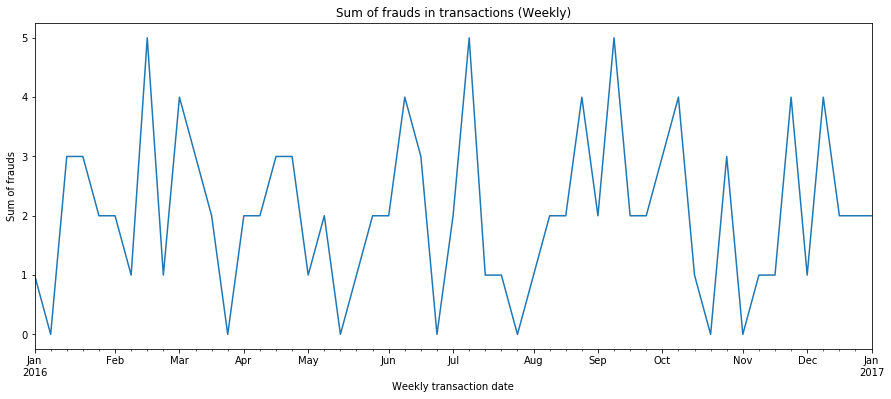

In [219]:
y_time.plot(figsize=(15, 6))
plt.ylabel('Sum of frauds')
plt.xlabel('Weekly transaction date')
plt.title('Sum of frauds in transactions (Weekly)')
plt.show()

Is better to do it weekly, because we only have 1 year of data and monthly would be so few data.

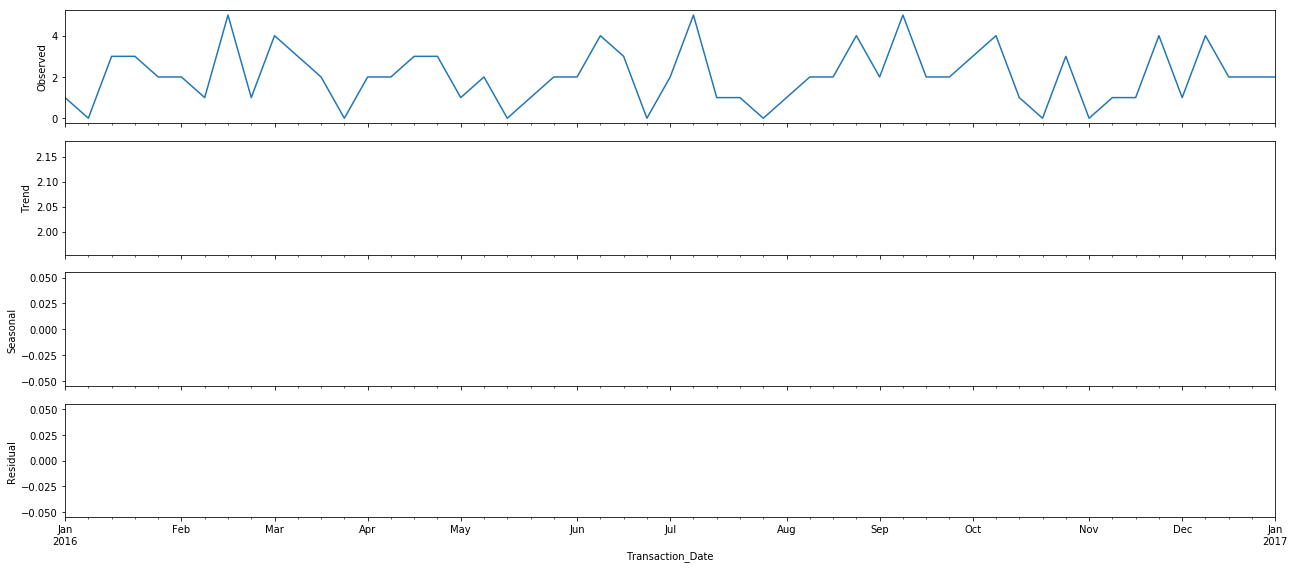

In [220]:
decomposition = sm.tsa.seasonal_decompose(y_time, model = 'additive')
fig = decomposition.plot()
plt.show()

As we see there's no seasonality.